In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def load_glove_dict (glove_file):    
    word_dict = {}
    with open(glove_file, 'r') as f:
        for line in f:
            split = line.split()
            word = split[0]
            vector = np.array([float(v) for v in split[1:]])
            word_dict[word] = vector
    return word_dict


def get_glove_vector (g_dict, word):
    try:
        vector = g_dict[word.lower()]
    except KeyError:
        vector_len = len(g_dict['test'])
        vector = np.array([0.]*vector_len)
    return vector


In [ ]:
# !wget https://zenodo.org/record/3237458/files/glove.twitter.27B.50d.txt.gz

# !gunzip /content/glove.twitter.27B.50d.txt.gz

In [ ]:
g_file = '/content/glove.twitter.27B.50d.txt'
g_dict = load_glove_dict(g_file)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd

def neel_sentences(gs_file, tsv_file):
    """NEEL2006 sentences from gs and tsv files
    
    Seperating NEEL data into individual sentences with corresponding tags
    
    arguments: gs_file, tsv_file
    returns: sentences, entities, unknown tweet IDs
    """
    
    gs_col_names=['tweet_id','start','end','uri', 'confidence', 'entity']
    tsv_col_names=['tweet_id','text']
    tweets_dict = {}
    data_dict = {}
    seen_ids = set()
    sent = []
    entity = []
    unknown_indicies = set()
    
    gs_df = pd.read_table(gs_file, sep = '\t', header=None, names=gs_col_names)
    # fixes entity label at index 4805 that is incorrect
    if len(gs_df['entity']) > 4805 and gs_df['entity'][4805] == 'Organization373937812812615000':
        gs_df.at[4805, 'entity'] = 'Organization'
    
    tsv_df = pd.read_table(tsv_file, sep = ',', header=None, names=tsv_col_names)
    # strip '|' character from the edges of tsv_df column values
    tsv_df['tweet_id'] = tsv_df['tweet_id'].apply(lambda x: str(x).strip('|'))
    tsv_df['text'] = tsv_df['text'].apply(lambda x: str(x).strip('|'))

    for index, row in tsv_df.iterrows():
        tweets_dict[row['tweet_id']] = row['text']
    
    for index, row in gs_df.iterrows():
        tweet_id = str(row['tweet_id'])
        start = row['start']
        end = row['end']
        old_ent = row['entity']
        
        # Rename entity values as PER, LOC, ORG, MISC, O
        if old_ent in ('Character', 'Person'):
            new_ent = 'PER'
        elif old_ent == 'Location':
            new_ent = 'LOC'
        elif old_ent == 'Organization':
            new_ent = 'ORG'
        else:
            new_ent = 'MISC'
        
        try:
            text = tweets_dict[tweet_id]
            if tweet_id not in seen_ids:
                seen_ids.add(tweet_id)
                words = word_tokenize(text)
                labels = ['O']*len(words)
            else:
                words = data_dict[tweet_id]['words']
                labels = data_dict[tweet_id]['labels']
            assert(len(words)==len(labels))
            ent_words = word_tokenize(text[start:end])
            for e in ent_words:
                for i in range(len(words)):
                    if e == words[i]:
                        labels[i] = new_ent
            data_dict[tweet_id] = {'words': words, 'labels': labels}
        except KeyError:
            unknown_indicies.add(tweet_id)
    
    for key in data_dict:
        sent.append(data_dict[key]['words'])
        entity.append(data_dict[key]['labels'])
    
    return sent, entity, unknown_indicies


In [ ]:
def neel_words(gs_file, tsv_file):
    """NEEL2006 words from gs and tsv files
    
    Seperating NEEL data into individual words with corresponding tags
    
    arguments: gs_file, tsv_file
    returns: words, entities, unknown tweet IDs
    """
    
    all_words = []
    all_entities = []
    all_errors = set()
    
    sent, entity, errors = neel_sentences(gs_file, tsv_file)

    for se in sent:
        for w in se:
            all_words.append(w)
    for en in entity:
        for e in en:
            all_entities.append(e)
    for er in errors:
        all_errors.add(er)
            
    return all_words, all_entities, all_errors
    

In [ ]:
train_gs_file = r'/content/drive/MyDrive/Dataset/NER_Dataset/NEEL2006/training_neel.gs'
train_tsv_file = r'/content/drive/MyDrive/Dataset/NER_Dataset/NEEL2006/training.tsv'
test_gs_file = r'/content/drive/MyDrive/Dataset/NER_Dataset/NEEL2006/test_neel.gs'
test_tsv_file = r'/content/drive/MyDrive/Dataset/NER_Dataset/NEEL2006/test.tsv'

org_train_words, train_entity, train_errors = neel_words(train_gs_file, train_tsv_file)
org_test_words, test_entity, test_errors = neel_words(test_gs_file, test_tsv_file)


In [ ]:
combined_words = org_train_words + org_test_words

In [ ]:
print(len(org_train_words))
print(len(org_test_words))
print(len(combined_words))

69516
5410
74926


In [ ]:
char_set = set()
char_dict = {}
max_word_len = 0

for word in combined_words:
  if len(word) > max_word_len:
    max_word_len = len(word)

  for char in word:
    char_set.add(char)

for i, char in enumerate(char_set):
  char_dict[char] = int(i)+1

for key in char_dict.keys():
  if char_dict[key] == 0:
    raise KeyError("ERROR: index 0 is used with key:", key)

print("Maximum word lentgh: ", max_word_len)
print("Char set lentgh: ", len(char_dict))

Maximum word lentgh:  82
Char set lentgh:  264


### Convert training and test words into padded int vectors using char dictonary

In [ ]:
train_sentence, _, _ = neel_sentences(train_gs_file, train_tsv_file)

train_sentence[0]

['Is',
 'Intel',
 'About',
 'to',
 'Get',
 'Hit',
 'by',
 'a',
 'BRIC',
 '?',
 '-',
 'BRIC',
 'countries',
 'have',
 'supported',
 'Intel',
 "'s",
 'growth',
 ';',
 'will',
 'that',
 'continue',
 '?',
 'http',
 ':',
 '//ow.ly/1e8bpH']

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec()
w2v_model.build_vocab(train_sentence)
w2v_model.train(train_sentence, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

#w2v_model.save("word2vec.model")

(993434, 2085480)

In [ ]:
# from sklearn.decomposition import PCA
# from matplotlib import pyplot as plt

# X = w2v_model[w2v_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)

# plt.scatter(result[:, 0], result[:, 1])
# words = list(w2v_model.wv.vocab)
# for i, word in enumerate(words):
# 	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# plt.show()

In [ ]:
def word2vec(words):
  out = []
  for word in words:
    temp = []
    for char in word:
      temp.append(char_dict[char])
    
    out.append(temp)

  return np.array(out)

In [ ]:
from keras.preprocessing import sequence

maxlen = 90

train_words = sequence.pad_sequences(word2vec(org_train_words), maxlen=maxlen)
test_words = sequence.pad_sequences(word2vec(org_test_words), maxlen=maxlen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
labels = np.unique(train_entity)
labels

array(['LOC', 'MISC', 'O', 'ORG', 'PER'], dtype='<U4')

### Add GolVe features

In [ ]:
def set_glove_features(org_words_list, word_padding_list):
  glove_list = []
  for i in range(len(word_padding_list)):
    glove_list.append(np.concatenate((word_padding_list[i], get_glove_vector(g_dict, org_words_list[i]))))
  return np.array(glove_list, dtype=np.float32)

train_glove = set_glove_features(org_train_words, train_words) 
test_glove = set_glove_features(org_test_words, test_words) 


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_entity),
                                                 y=train_entity)

class_weights = {k: v for k,v in enumerate(class_weights)}
class_weights

{0: 6.927354260089686,
 1: 5.399300970873786,
 2: 0.23220375782881003,
 3: 7.403194888178914,
 4: 4.37070103740962}

In [ ]:
def one_hot_encode_fit(labels, entities):
  label_to_int = dict((c, i) for i, c in enumerate(labels))
  int_to_label = dict((i, c) for i, c in enumerate(labels))

  return label_to_int, int_to_label


def one_hot_encode_transform(labels, label_to_int, entities):
  integer_encoded = [label_to_int[char] for char in entities]
  onehot_encoded = list()
  for value in integer_encoded:
    letter = [0 for _ in range(len(labels))]
    letter[value] = 1
    onehot_encoded.append(letter)

  return np.array(onehot_encoded)


def one_hot_encode_reverse(labels, int_to_label, encoded_entities):
    entities = [e.argmax() for e in encoded_entities]
    entities = [int_to_label[x] for x in entities]  

    return np.array(entities)

In [ ]:
label_to_int, int_to_label = one_hot_encode_fit(labels, train_entity)

train_entities = one_hot_encode_transform(labels, label_to_int, train_entity)
test_entities = one_hot_encode_transform(labels, label_to_int, test_entity)

In [ ]:
int_to_label, label_to_int

({0: 'LOC', 1: 'MISC', 2: 'O', 3: 'ORG', 4: 'PER'},
 {'LOC': 0, 'MISC': 1, 'O': 2, 'ORG': 3, 'PER': 4})

In [ ]:
def accuracy (expected, predicted):
    total = 0
    correct = 0
    for i in range(len(expected)):
        total += 1
        if (expected[i] == predicted[i]):
            correct += 1
    print('accuracy = %d / %d = %lf' % (correct, total, correct/total))

In [ ]:
def entity_count (expected):

    n_org = 0
    n_per = 0
    n_loc = 0
    n_misc = 0
    n_o = 0
    
    for e in expected:
        if e == 'ORG':
            n_org = n_org + 1
        elif e == 'PER':
            n_per = n_per + 1
        elif e == 'LOC':
            n_loc = n_loc + 1
        elif e == 'MISC':
            n_misc = n_misc + 1
        elif e == 'O':
            n_o = n_o + 1
    
    print('ORG:', n_org)
    print('PER:', n_per)
    print('LOC:', n_loc)
    print('MISC:', n_misc)
    print('O:', n_o)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn
import pandas as pd


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.keys()],
                  columns = [i for i in label_encoder.keys()])
    plt.figure(figsize = (10,10))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.keys()))

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
                                  
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(20,20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(list(label_encoder.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Classes Characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
max_features = len(char_set) + 1
glove_len = 50
batch_size = 128
epochs = 100
dropout = 0.5

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Recall, Precision

def build_model():
  model = Sequential()
  model.add(Embedding(max_features, 480, input_length=maxlen + glove_len))
  model.add(Dropout(dropout))
  model.add(Bidirectional(LSTM(240, return_sequences=True)))
  model.add(Bidirectional(LSTM(80)))
  model.add(Dense(len(labels), activation='softmax'))
  model.compile('adam', 'categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])   

  model.summary()

  return model

In [ ]:
model = build_model()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 480)          127200    
                                                                 
 dropout_6 (Dropout)         (None, 140, 480)          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 140, 480)         1384320   
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 160)              359040    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 5)                 805       
                                                                 
Total params: 1,871,365
Trainable params: 1,871,365
No

In [ ]:
# !pip install livelossplot

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras


model_weights_file_path = "glove_bilstm_best_model_weights.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=0, mode='max', min_delta=0.0001, cooldown=0, min_lr=0)
plotlosses = PlotLossesKeras()

call_backs = [checkpoint, early_stopping, plotlosses, lr_reduce]



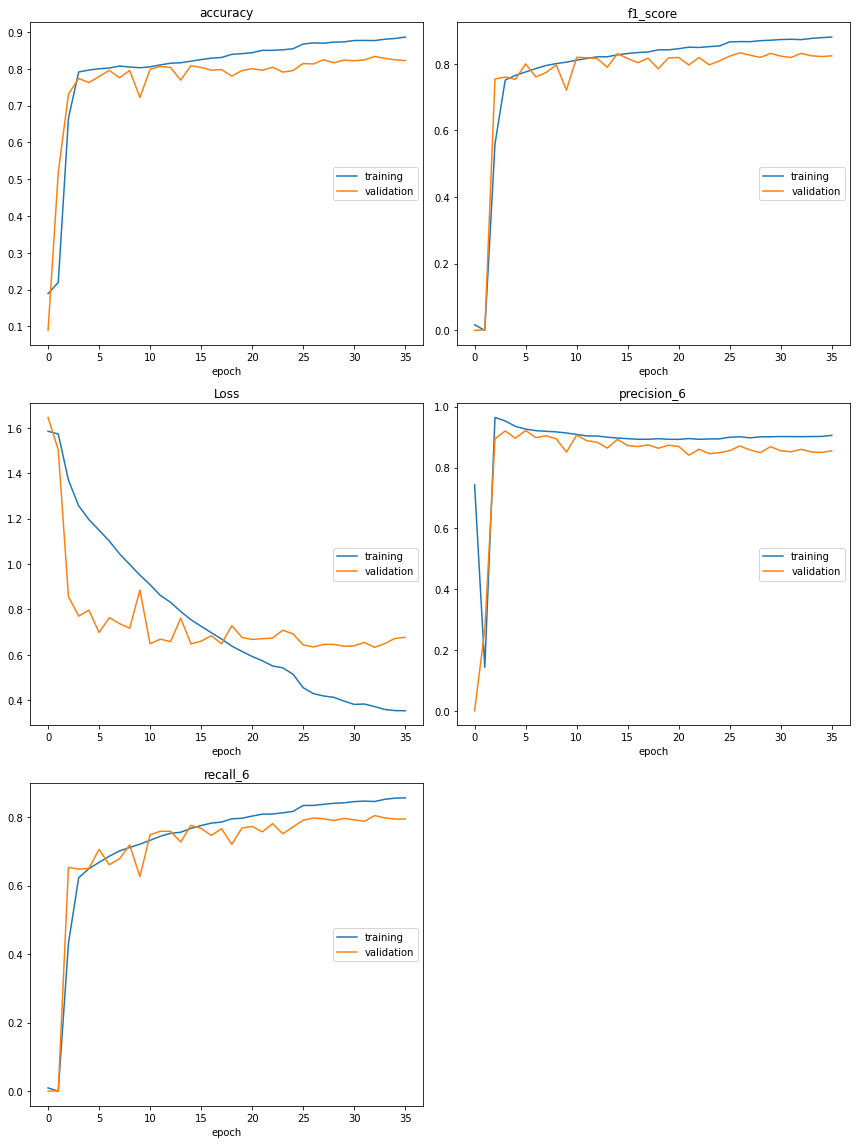

accuracy
	training         	 (min:    0.189, max:    0.887, cur:    0.887)
	validation       	 (min:    0.089, max:    0.834, cur:    0.823)
f1_score
	training         	 (min:    0.000, max:    0.880, cur:    0.880)
	validation       	 (min:    0.000, max:    0.833, cur:    0.824)
Loss
	training         	 (min:    0.354, max:    1.585, cur:    0.354)
	validation       	 (min:    0.633, max:    1.646, cur:    0.677)
precision_6
	training         	 (min:    0.143, max:    0.965, cur:    0.906)
	validation       	 (min:    0.000, max:    0.922, cur:    0.855)
recall_6
	training         	 (min:    0.000, max:    0.856, cur:    0.856)
	validation       	 (min:    0.000, max:    0.805, cur:    0.795)
544/544 [==============================] - 49s 91ms/step - loss: 0.3541 - accuracy: 0.8865 - precision_6: 0.9056 - recall_6: 0.8565 - f1_score: 0.8801 - val_loss: 0.6770 - val_accuracy: 0.8226 - val_precision_6: 0.8547 - val_recall_6: 0.7946 - val_f1_score: 0.8237 - lr: 5.0000e-04
Epoch 37/100
 

In [ ]:
history = model.fit(train_glove, train_entities,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[test_glove, test_entities],
                    class_weight=class_weights,
                    callbacks=call_backs,
                    verbose=1)

In [ ]:
model.load_weights("/content/glove_bilstm_best_model_weights.h5")

In [ ]:
model.evaluate(test_glove, test_entities)

170/170 [==============================] - 3s 17ms/step - loss: 0.6776 - accuracy: 0.8146 - precision_4: 0.8932 - recall_4: 0.7449 - f1_score: 0.8096


[0.6775602102279663,
 0.8146026134490967,
 0.8931737542152405,
 0.7449167966842651,
 0.8095957040786743]

In [ ]:
y_hat = model.predict(test_glove)
y_hat = np.argmax(y_hat, axis=1)

In [ ]:
entity_count(test_entity)
accuracy(np.argmax(test_entities, axis=1), y_hat)

ORG: 146
PER: 380
LOC: 37
MISC: 484
O: 4363
accuracy = 4407 / 5410 = 0.814603


Accuracy:  0.8146025878003696
Precision::  0.8146025878003696
Recall::  0.8146025878003696
F1_Score::  0.8146025878003696

Macro precision_recall_fscore_support (macro) average
(0.5544929907914138, 0.44564016119669986, 0.46872060539401145, None)

Macro precision_recall_fscore_support (micro) average
(0.8146025878003696, 0.8146025878003696, 0.8146025878003696, None)

Macro precision_recall_fscore_support (weighted) average
(0.7829163269486036, 0.8146025878003696, 0.7886509719537608, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         LOC       0.43      0.06      0.11       256
        MISC       0.67      0.51      0.58       626
           O       0.87      0.98      0.92      3899
         ORG       0.20      0.15      0.17       189
         PER       0.60      0.52      0.56       440

    accuracy                           0.81      5410
   macro avg       0.55      0.45      0.47      5410
weighted avg       0.78      0.8

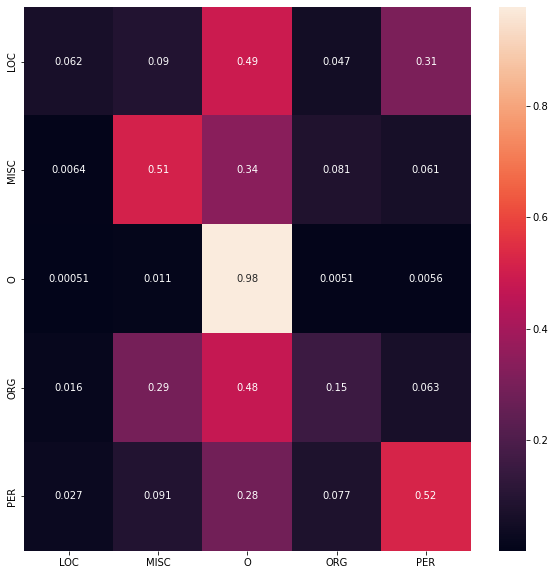

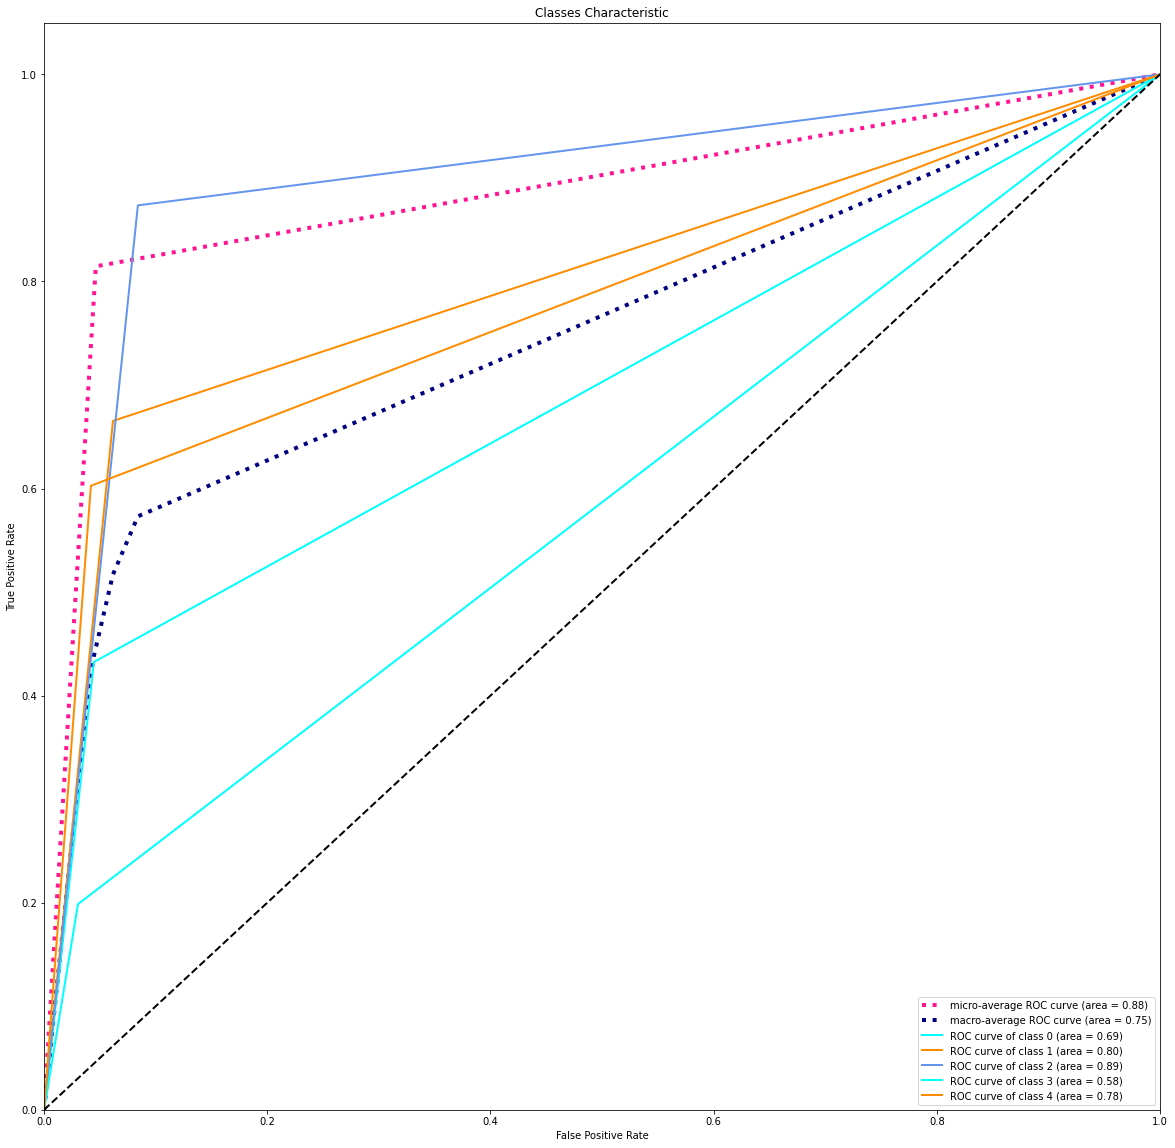

In [ ]:
print_score(np.argmax(test_entities, axis=1), y_hat , label_to_int)

y_hat_ohe = np.eye(np.max(y_hat) + 1)[y_hat] 

ROC_plot(testa_entities, y_hat_ohe, int_to_label, len(labels))